# libraries

In [81]:
import librosa
#import librosa.display
import setuptools

from numpy.distutils.core import setup
%pylab inline --no-import-all
#from scikits.audiolab import wavread
from scipy import signal
import matplotlib.pyplot as plt
from scipy.io import wavfile
import math
import numpy as np
from numpy.fft import fft
import pylab
#import mir_eval
import seaborn
seaborn.set(style="ticks")

Populating the interactive namespace from numpy and matplotlib


/home/mlbd/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['pylab']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [82]:
import numpy as np
from matplotlib import pyplot as pl
import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers.core import Dense, Dropout, Flatten
from keras.optimizers import RMSprop
from keras.utils import np_utils
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Input
from sklearn import metrics as me
from scipy import stats

%matplotlib inline

# Data Loading

In [84]:
with open(dir+"signals", 'rb') as f:
    signals = pickle.load(f)
    
with open(dir+"signals_N", 'rb') as f:
    signals_N = pickle.load(f)

# Data processing and preparation   

In [85]:
# load spectrogram of becase 
X_data_B=np.asarray(spectrogram(signals,False,sample_rate))
y_data_B=np.ones(len(X_data_B))  # 1:becasse, o: non becasse

# load spectrogram of non-becase 
data_inter=spectrogram(signals_N,False,sample_rate)

# delete error rows from "non becasse" sampling
rows_to_delete =[]
for i in range(len(data_inter)):
    if data_inter[i].shape[0] <> 129 or data_inter[i].shape[1] <> 1607:
        rows_to_delete.append(i)
        
for i,row in enumerate(rows_to_delete):
    del data_inter[row]   
        
# load spectrogram of non-becase final
X_data_N=np.asarray(data_inter)
y_data_N=np.zeros(len(X_data_N))  # 1:becasse, o: non becasse

# combine data "becasse" and "no becasse"
X_data = np.concatenate((X_data_B, X_data_N),axis=0)
y_data = np.concatenate((y_data_B ,y_data_N),axis=0)


In [86]:
# sampling data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
                        X_data, y_data, test_size=0.3, stratify=y_data)

print "X_train.shape : ", X_train.shape
print "y_train.shape : ", y_train.shape
print "X_test.shape : ", X_test.shape
print "y_test.shape : ", y_test.shape


n_train, height, width = X_train.shape
n_test, _, _ = X_test.shape

X_train = X_train.reshape(n_train, 1, height, width).astype('float32')
X_test = X_test.reshape(n_test, 1, height, width).astype('float32')

maxi_train_value=np.max(X_train[2])
maxi_test_value=np.max(X_test[2])


X_train /= float(maxi_train_value)
X_test /= float(maxi_test_value)

n_classes = 2

print n_train, 'train samples'
print n_test, 'test samples'

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)


# initial vars X_data and y_data to release memory
X_data=[]
y_data=[]

X_train.shape :  (1399, 129, 1607)
y_train.shape :  (1399,)
X_test.shape :  (600, 129, 1607)
y_test.shape :  (600,)
1399 train samples
600 test samples


# Data modeling

In [87]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
def create_model(dropoutRate1=0.25,dropoutRate2=0.25,learningRate=0.0000000000000001):
    # create model
    model = Sequential()

    model.add(Convolution2D(9, 5, 5, activation='relu', input_shape=(1, height, width)))
    #model.add(Convolution2D(9, 5, 5, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(dropoutRate1))

    model.add(Flatten())
    #model.add(Dense(25, activation='relu'))
    model.add(Dropout(dropoutRate2))
    model.add(Dense(n_classes, activation='softmax'))
    model.summary()

    # Compile model
    keras.optimizers.RMSprop(lr=0.0000000000000001, rho=0.9, epsilon=1e-08, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

    return model

def create_model_MoreComplex(dropoutRate1=0.25,dropoutRate2=0.25,learningRate=0.0000000000000001):
    # create model
    model = Sequential()

    model.add(Convolution2D(9, 5, 5, activation='relu', input_shape=(1, height, width)))
    model.add(Convolution2D(9, 5, 5, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(dropoutRate1))

    model.add(Flatten())
    model.add(Dense(25, activation='relu'))
    model.add(Dropout(dropoutRate2))
    model.add(Dense(n_classes, activation='softmax'))
    model.summary()

    # Compile model
    
    keras.optimizers.RMSprop(lr=learningRate, rho=0.9, epsilon=1e-08, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

    return model

In [88]:
print X_train.shape
print Y_train.shape

print X_test.shape
print Y_test.shape


(1399, 1, 129, 1607)
(1399, 2)
(600, 1, 129, 1607)
(600, 2)


# Run models with def_create_model

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score
# defin parameters 
learningRate=[0.0,1e-10,1e-100]
dropoutRate1_tab=[0.25,0.5]
dropoutRate2_tab=[0.25,0.5]
batch_size_tab = [64,128]
n_epoch = 10

# result variables
train_score =[]
train_accuracy=[]
train_precisions=[]
train_recalls=[]
train_fscores=[]
train_supports=[]
train_params=[]

# result variables
test_score =[]
accuracy=[]
precisions=[]
recalls=[]
fscores=[]
supports=[]
params=[]

# run
for batch_size in batch_size_tab:
    for lr in learningRate:
        for dropoutRate1 in dropoutRate1_tab:
            for dropoutRate2 in dropoutRate2_tab:
                model=create_model(dropoutRate1,dropoutRate2,lr)
                history = model.fit(X_train, Y_train, batch_size=batch_size,nb_epoch=n_epoch, verbose=1, validation_data=(X_test, Y_test))

                # load parameter 
                param=str(batch_size)+"|"+str(lr)+"|"+str(dropoutRate1)+"|"+str(dropoutRate2)
                params.append(param)

                # Prediction on test
                y_test_pred=model.predict_classes(X_test)
                # test score & accuracy
                scores = model.evaluate(X_test, Y_test, verbose=0)
                test_score.append(scores[0])
                accuracy.append(scores[1])
                # precision, recall, fscore, support
                precision, recall, fscore, support = score(y_true=y_test, y_pred=y_test_pred)
                precisions.append(precision)
                recalls.append(recall)
                fscores.append(fscore)
                supports.append(support)

                # Prediction on train
                y_train_pred=model.predict_classes(X_train)
                # test score & accuracy
                scores = model.evaluate(X_train, Y_train, verbose=0)
                train_score.append(scores[0])
                train_accuracy.append(scores[1])
                # precision, recall, fscore, support
                train_precision, recall, fscore, support = score(y_true=y_train, y_pred=y_train_pred)
                train_precisions.append(precision)
                train_recalls.append(recall)
                train_fscores.append(fscore)
                train_supports.append(support)


/home/mlbd/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(9, (5, 5), activation="relu", input_shape=(1, 129, 1...)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 9, 125, 1603)      234       
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 9, 62, 801)        0         
_________________________________________________________________
dropout_77 (Dropout)         (None, 9, 62, 801)        0         
_________________________________________________________________
flatten_39 (Flatten)         (None, 446958)            0         
_________________________________________________________________
dropout_78 (Dropout)         (None, 446958)            0         
_________________________________________________________________
dense_40 (Dense)             (None, 2)                 893918    
Total params: 894,152.0
Trainable params: 894,152.0
Non-trainable params: 0.0
________________________________________________________________

In [62]:
import sys
sys.stdout.write("{:<40}{:<10}{:<10}{:<15}{:<15}{:<15}{:<10}\n".format('Batch_size|lr|dropoutrate','testScore','accuracy','precision','recall','fscores','support'))
for i,parm in enumerate(params):
    sys.stdout.write("{:<40}{:<10}{:<10}{:<15}{:<15}{:<15}{:<10}\n"
                     .format(parm
                             ,round(test_score[i],2)
                             ,round(accuracy[i],2)
                             ,str(round(precisions[i][0],2)) +' , '+str(round(precisions[i][1],2))
                             ,str(round(recalls[i][0],2)) +', '+str(round(recalls[i][1],2))
                             ,str(round(fscores[i][0],2)) +' , '+str(round(fscores[i][1],2))
                             ,supports[i][0]
                             )
                    )
   

Batch_size|lr|dropoutrate               testScore accuracy  precision      recall         fscores        support   
64|0.0|0.25|0.25                        0.48      0.92      0.89 , 0.95    0.95, 0.88     0.92 , 0.91    300       
64|0.0|0.25|0.5                         0.53      0.9       0.86 , 0.95    0.96, 0.85     0.91 , 0.9     300       
64|0.0|0.5|0.25                         0.47      0.91      0.88 , 0.95    0.95, 0.87     0.91 , 0.91    300       
64|0.0|0.5|0.5                          0.44      0.93      0.92 , 0.94    0.94, 0.91     0.93 , 0.93    300       
64|0.0|0.25|0.25                        0.45      0.92      0.9 , 0.95     0.95, 0.89     0.93 , 0.92    300       
64|0.0|0.25|0.5                         0.48      0.94      0.93 , 0.95    0.95, 0.93     0.94 , 0.94    300       
64|0.0|0.5|0.25                         0.51      0.95      0.95 , 0.94    0.94, 0.95     0.95 , 0.95    300       
64|0.0|0.5|0.5                          0.42      0.91      0.87 , 0.95 

In [63]:
import sys
sys.stdout.write("{:<41}{:<10}{:<13}{:<13}{:<15}{:<13}{:<13}\n"
                 .format('Batch_size|lr|dropoutrate1'
                         ,'testScore','traiinScore'
                         ,'testAccuracy','trainAccuracy'
                         ,'testFscore','trainfscore'))
for i,parm in enumerate(params):
    sys.stdout.write("{:<41}{:<10}{:<13}{:<13}{:<14}{:<13}{:<13}\n"
                     .format(parm
                             ,round(test_score[i],2)
                             ,round(train_score[i],2)
                             ,round(accuracy[i],2)
                             ,round(train_accuracy[i],2)
                             ,str(round(fscores[i][0],2)) +', '+str(round(fscores[i][1],2))
                             ,str(round(train_fscores[i][0],2)) +', '+str(round(train_fscores[i][1],2))
                             )
                    )

Batch_size|lr|dropoutrate1               testScore traiinScore  testAccuracy trainAccuracy  testFscore   trainfscore  
64|0.0|0.25|0.25                         0.48      0.13         0.92         0.97          0.92, 0.91   0.97, 0.97   
64|0.0|0.25|0.5                          0.53      0.18         0.9          0.96          0.91, 0.9    0.96, 0.96   
64|0.0|0.5|0.25                          0.47      0.14         0.91         0.97          0.91, 0.91   0.97, 0.97   
64|0.0|0.5|0.5                           0.44      0.22         0.93         0.97          0.93, 0.93   0.97, 0.97   
64|0.0|0.25|0.25                         0.45      0.14         0.92         0.97          0.93, 0.92   0.98, 0.97   
64|0.0|0.25|0.5                          0.48      0.13         0.94         0.98          0.94, 0.94   0.98, 0.98   
64|0.0|0.5|0.25                          0.51      0.16         0.95         0.98          0.95, 0.95   0.98, 0.98   
64|0.0|0.5|0.5                           0.42      0.18

([<matplotlib.axis.XTick at 0x7f402c2dfb10>,
 <a list of 32 Text xticklabel objects>)

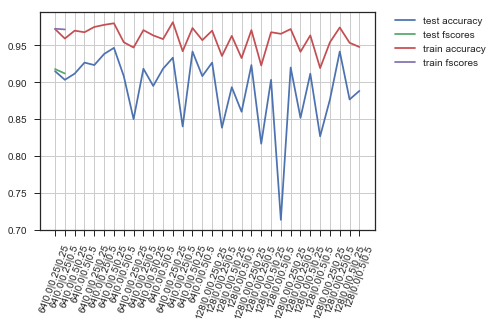

In [64]:
import matplotlib.pyplot as plt
plt.plot(accuracy, label='test accuracy')
pl.plot(fscores[:][0], label='test fscores')
plt.plot(train_accuracy, label='train accuracy')
pl.plot(train_fscores[:][0], label='train fscores')
pl.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
pl.grid()
plt.xticks(range(len(accuracy)),params,rotation=70)

# best parameter : batch_size=128, lr =0.0000000000001 , dropout =0.25

# Run models with create_model_MoreComplex

In [34]:
from sklearn.metrics import precision_recall_fscore_support as score
# defin parameters 
learningRate=[0.0,1e-10,1e-100]
dropoutRate_tab=[0.25,0.5]
batch_size_tab = [64,128]
n_epoch = 10

# result variables
train_score =[]
train_accuracy=[]
train_precisions=[]
train_recalls=[]
train_fscores=[]
train_supports=[]
train_params=[]

# result variables
test_score =[]
accuracy=[]
precisions=[]
recalls=[]
fscores=[]
supports=[]
params=[]

# run
for batch_size in batch_size_tab:
    for lr in learningRate:
        for dropoutRate in dropoutRate_tab:
            model=create_model_MoreComplex(dropoutRate,lr)
            history = model.fit(X_train, Y_train, batch_size=batch_size,nb_epoch=n_epoch, verbose=1, validation_data=(X_test, Y_test))

            # load parameter 
            param=str(batch_size)+"|"+str(lr)+"|"+str(dropoutRate)
            params.append(param)

            # Prediction on test
            y_test_pred=model.predict_classes(X_test)
            # test score & accuracy
            scores = model.evaluate(X_test, Y_test, verbose=0)
            test_score.append(scores[0])
            accuracy.append(scores[1])
            # precision, recall, fscore, support
            precision, recall, fscore, support = score(y_true=y_test, y_pred=y_test_pred)
            precisions.append(precision)
            recalls.append(recall)
            fscores.append(fscore)
            supports.append(support)

            # Prediction on train
            y_train_pred=model.predict_classes(X_train)
            # test score & accuracy
            scores = model.evaluate(X_train, Y_train, verbose=0)
            train_score.append(scores[0])
            train_accuracy.append(scores[1])
            # precision, recall, fscore, support
            train_precision, recall, fscore, support = score(y_true=y_train, y_pred=y_train_pred)
            train_precisions.append(precision)
            train_recalls.append(recall)
            train_fscores.append(fscore)
            train_supports.append(support)

/home/mlbd/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:29: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(9, (5, 5), activation="relu", input_shape=(1, 129, 1...)`
/home/mlbd/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:30: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(9, (5, 5), activation="relu")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 9, 125, 1603)      234       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 9, 121, 1599)      2034      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 60, 799)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 9, 60, 799)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 431460)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 25)                10786525  
_________________________________________________________________
dropout_10 (Dropout)         (None, 25)                0         
__________

KeyboardInterrupt: 

In [59]:
import sys
sys.stdout.write("{:<40}{:<10}{:<10}{:<15}{:<15}{:<15}{:<10}\n".format('Batch_size|lr|dropoutrate','testScore','accuracy','precision','recall','fscores','support'))
for i,parm in enumerate(params):
    sys.stdout.write("{:<40}{:<10}{:<10}{:<15}{:<15}{:<15}{:<10}\n"
                     .format(parm
                             ,round(test_score[i],2)
                             ,round(accuracy[i],2)
                             ,str(round(precisions[i][0],2)) +' , '+str(round(precisions[i][1],2))
                             ,str(round(recalls[i][0],2)) +', '+str(round(recalls[i][1],2))
                             ,str(round(fscores[i][0],2)) +' , '+str(round(fscores[i][1],2))
                             ,supports[i][0]
                             )
                    )

Batch_size|lr|dropoutrate               testScore accuracy  precision      recall         fscores        support   
64|1e-07|0.25                           0.75      0.94      0.91 , 0.98    0.98, 0.91     0.95 , 0.94    300       
64|1e-07|0.5                            0.99      0.92      0.88 , 0.98    0.98, 0.87     0.93 , 0.92    300       
64|1e-11|0.25                           0.78      0.94      0.91 , 0.98    0.98, 0.91     0.95 , 0.94    300       
64|1e-11|0.5                            0.71      0.93      0.89 , 0.97    0.98, 0.88     0.93 , 0.93    300       
64|1e-13|0.25                           0.99      0.93      0.89 , 0.98    0.98, 0.87     0.93 , 0.92    300       
64|1e-13|0.5                            0.86      0.92      0.88 , 0.97    0.97, 0.87     0.93 , 0.92    300       
128|1e-07|0.25                          1.46      0.89      0.83 , 0.98    0.98, 0.8      0.9 , 0.88     300       
128|1e-07|0.5                           0.83      0.93      0.89 , 0.98 

In [60]:
import sys
sys.stdout.write("{:<41}{:<10}{:<13}{:<13}{:<15}{:<13}{:<13}\n"
                 .format('Batch_size|lr|dropoutrate1'
                         ,'testScore','traiinScore'
                         ,'testAccuracy','trainAccuracy'
                         ,'testFscore','trainfscore'))
for i,parm in enumerate(params):
    sys.stdout.write("{:<41}{:<10}{:<13}{:<13}{:<14}{:<13}{:<13}\n"
                     .format(parm
                             ,round(test_score[i],2)
                             ,round(train_score[i],2)
                             ,round(accuracy[i],2)
                             ,round(train_accuracy[i],2)
                             ,str(round(fscores[i][0],2)) +', '+str(round(fscores[i][1],2))
                             ,str(round(train_fscores[i][0],2)) +', '+str(round(train_fscores[i][1],2))
                             )
                    )

Batch_size|lr|dropoutrate1               testScore traiinScore  testAccuracy trainAccuracy  testFscore   trainfscore  
64|1e-07|0.25                            0.75      0.1          0.94         0.98          0.95, 0.94   0.98, 0.98   
64|1e-07|0.5                             0.99      0.19         0.92         0.97          0.93, 0.92   0.97, 0.97   
64|1e-11|0.25                            0.78      0.12         0.94         0.98          0.95, 0.94   0.98, 0.98   
64|1e-11|0.5                             0.71      0.19         0.93         0.98          0.93, 0.93   0.98, 0.98   
64|1e-13|0.25                            0.99      0.14         0.93         0.98          0.93, 0.92   0.98, 0.98   
64|1e-13|0.5                             0.86      0.22         0.92         0.94          0.93, 0.92   0.94, 0.93   
128|1e-07|0.25                           1.46      0.53         0.89         0.87          0.9, 0.88    0.89, 0.86   
128|1e-07|0.5                            0.83      0.19

([<matplotlib.axis.XTick at 0x7f02d06c50d0>,
 <a list of 12 Text xticklabel objects>)

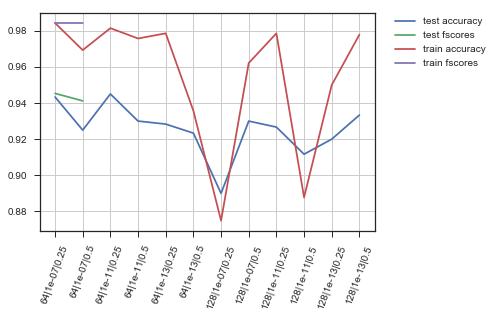

In [61]:
import matplotlib.pyplot as plt
plt.plot(accuracy, label='test accuracy')
pl.plot(fscores[:][0], label='test fscores')
plt.plot(train_accuracy, label='train accuracy')
pl.plot(train_fscores[:][0], label='train fscores')
pl.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
pl.grid()
plt.xticks(range(len(accuracy)),params,rotation=70)

# Display best results

In [75]:
# best parameter of create_model: batch_size=128, lr =0.0000000000001 , dropout =0.25
# best parameter of create_model_complexe: taux varie bpc et moins stable
# re-run model with parameters giving the best result
dropoutRate1=0.50
dropoutRate2=0.50
learningRate=0.0
batch_size = 128
n_epoch = 20
# choix between def create_model or create_model_MoreComplex
model=create_model(dropoutRate1,dropoutRate2,learningRate)  
history = model.fit(X_train, Y_train, batch_size=batch_size, 
                nb_epoch=n_epoch, verbose=1, validation_data=(X_test, Y_test))

# Prediction
y_test_pred=model.predict_classes(X_test)

/home/mlbd/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(9, (5, 5), activation="relu", input_shape=(1, 129, 1...)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 9, 125, 1603)      234       
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 9, 62, 801)        0         
_________________________________________________________________
dropout_75 (Dropout)         (None, 9, 62, 801)        0         
_________________________________________________________________
flatten_38 (Flatten)         (None, 446958)            0         
_________________________________________________________________
dropout_76 (Dropout)         (None, 446958)            0         
_________________________________________________________________
dense_39 (Dense)             (None, 2)                 893918    
Total params: 894,152.0
Trainable params: 894,152.0
Non-trainable params: 0.0
________________________________________________________________

('Train score:', 0.11285354622677661)
('Train accuracy:', 0.97283774124374556)
('Test score:', 0.51461805144945783)
('Test accuracy:', 0.90833333412806194)


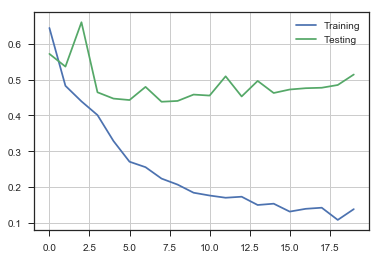

In [76]:
# Test score & accuracy
pl.plot(history.history['loss'], label='Training')
pl.plot(history.history['val_loss'], label='Testing')
pl.legend()
pl.grid()

score = model.evaluate(X_train, Y_train, verbose=0)
print('Train score:', score[0])
print('Train accuracy:', score[1])

score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

In [64]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



Confusion matrix, without normalization
[[293   7]
 [ 42 258]]
Normalized confusion matrix
[[ 0.97666667  0.02333333]
 [ 0.14        0.86      ]]


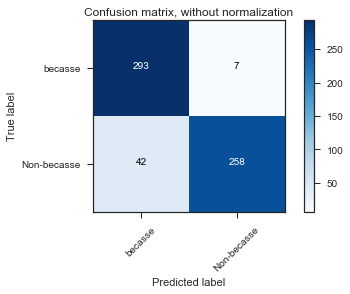

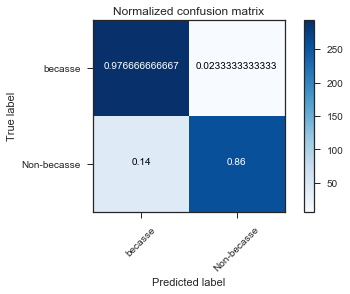

In [66]:
# Display confuson matrix
import sklearn.metrics as skmetrics

class_names=['becasse', 'Non-becasse']
cnf_matrix = skmetrics.confusion_matrix(y_true=y_test, y_pred=y_test_pred)

# Plot non-normalized confusion matrix
print "\n"
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

In [67]:
# Display different evaluating criteria 
print skmetrics.classification_report(y_true=y_test, y_pred=y_test_pred,target_names=class_names)


             precision    recall  f1-score   support

    becasse       0.87      0.98      0.92       300
Non-becasse       0.97      0.86      0.91       300

avg / total       0.92      0.92      0.92       600



In [66]:
'''
from sklearn.metrics import f1_score
# Precision of the positive class in binary classification or weighted average of the precision of each class for the multiclass task.
from sklearn.metrics import precision_score 
f1_score =f1_score(y_true=y_test, y_pred=y_test_pred)
precision_score =precision_score(y_true=y_test, y_pred=y_test_pred)


batch_size = 128
n_epoch = 10
model=create_model()
history = model.fit(X_train, Y_train, batch_size=batch_size, 
                    nb_epoch=n_epoch, verbose=1, validation_data=(X_test, Y_test))
                    

learningRate=0.0000000000000001
dropoutRate1=0.25
dropoutRate2=0.5
batch_size_Tab = [128,256]
n_epoch = 2
test_score =[]
accuracy=[]
precisions=[]
recalls=[]
fscores=[]
supports=[]
params=[]
for batch_size in (batch_size_Tab):
    # Training
    model=create_model(dropoutRate1,dropoutRate2,learningRate)
    history = model.fit(X_train, Y_train, batch_size=batch_size, 
                                nb_epoch=n_epoch, verbose=1, validation_data=(X_test, Y_test))
    # Prediction
    param=str(batch_size)+"-"+str(learningRate)
    params.append(param)
    scores = model.evaluate(X_test, Y_test, verbose=0)
    test_score.append(scores[0])
    accuracy.append(scores[1])
    
    precision, recall, fscore, support = score(y_true=y_test, y_pred=y_test_pred)
    precisions.append(precision)
    recalls.append(recall)
    fscores.append(fscore)
    supports.append(support)
'''


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_13 (Convolution2D) (None, 9, 125, 1603)  234         convolution2d_input_13[0][0]     
____________________________________________________________________________________________________
maxpooling2d_13 (MaxPooling2D)   (None, 9, 62, 801)    0           convolution2d_13[0][0]           
____________________________________________________________________________________________________
dropout_25 (Dropout)             (None, 9, 62, 801)    0           maxpooling2d_13[0][0]            
____________________________________________________________________________________________________
flatten_13 (Flatten)             (None, 446958)        0           dropout_25[0][0]                 
___________________________________________________________________________________________